In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5287d1a158ec7c0f7ffbe7d81c576521e5729d557bb34f78fa9761ad54bb7753
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **K-means**

Silhouette Score: 0.45994823920518635


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

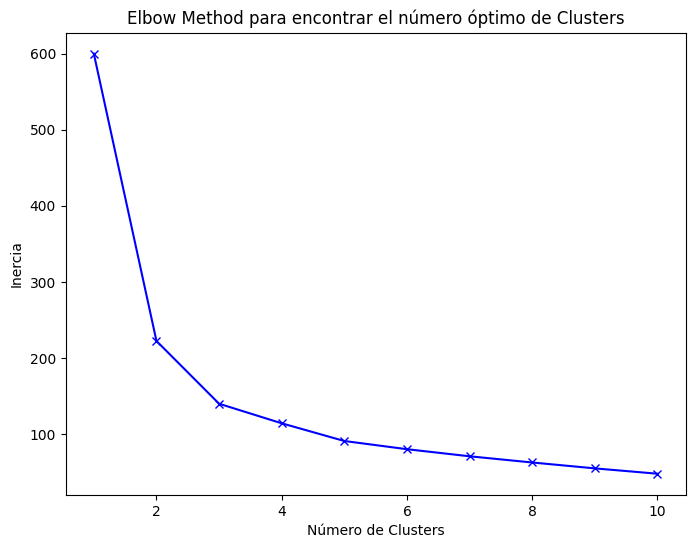

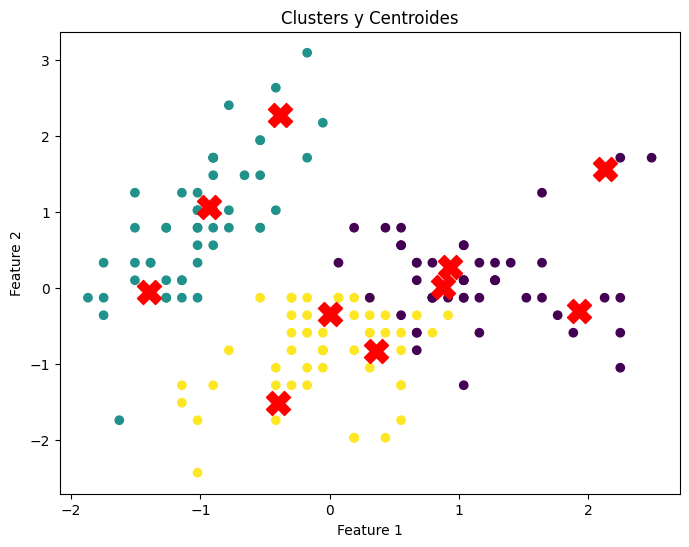

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear el modelo K-means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)

# Entrenar el modelo
kmeans.fit(X_scaled)

# Evaluar el modelo
labels = kmeans.labels_
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Gráfico de Inercia (Elbow Method)
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Elbow Method para encontrar el número óptimo de Clusters')
plt.show()

# Scatter Plot con Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('Clusters y Centroides')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn import datasets
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('KMeans_Clustering').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures')

# Crear el modelo K-means
kmeans = KMeans(k=3, seed=42, featuresCol='scaledFeatures', predictionCol='prediction')

# Entrenar el modelo
model = kmeans.fit(data)

# Evaluar el modelo
predictions = model.transform(data)
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', predictionCol='prediction')
silhouette = evaluator.evaluate(predictions)
print(f'Silhouette Score: {silhouette}')

# Mostrar los centroides
centers = model.clusterCenters()
print('Cluster Centers:')
for center in centers:
    print(center)

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
predictions_pd = predictions.toPandas()
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions_pd['scaledFeatures'].apply(lambda x: x[0]),
                         y=predictions_pd['scaledFeatures'].apply(lambda x: x[1]),
                         mode='markers',
                         marker=dict(color=predictions_pd['prediction']),
                         name='Data Points'))
for center in centers:
    fig.add_trace(go.Scatter(x=[center[0]], y=[center[1]], mode='markers', marker=dict(color='red', size=15), name='Centroid'))
fig.update_layout(title='Clusters y Centroides',
                  xaxis_title='Feature 1',
                  yaxis_title='Feature 2',
                  showlegend=False)
fig.show()

Silhouette Score: 0.6448079289144515
Cluster Centers:
[6.8887588  6.04493327 2.38782168 1.74828502]
[6.05788156 7.91761264 0.83006151 0.32128819]
[8.08674985 7.02050171 3.06927278 2.5427526 ]


# **DBScan**

Silhouette Score: 0.35651648142700726


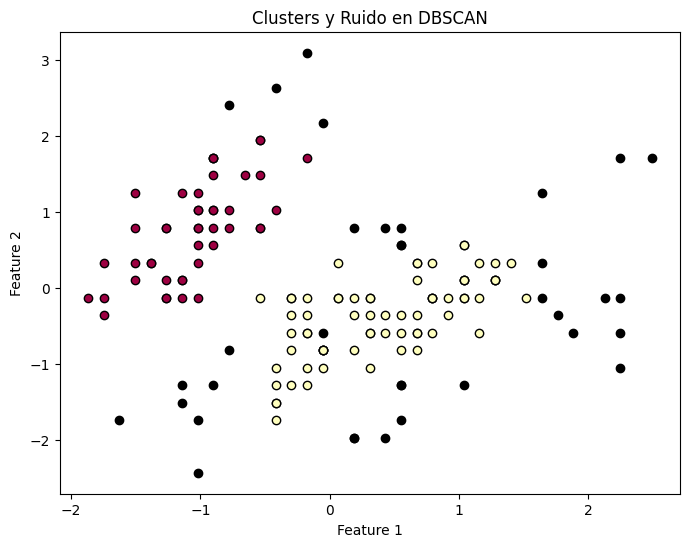

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Entrenar el modelo
labels = dbscan.fit_predict(X_scaled)

# Evaluar el modelo
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Gráfico de Clusters
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Negro para ruido
    class_member_mask = (labels == k)
    xy = X_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
plt.title('Clusters y Ruido en DBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import BisectingKMeans
from sklearn import datasets
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('DBSCAN_Clustering').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures')

# Crear el modelo DBSCAN (PySpark no tiene una implementación directa de DBSCAN, así que usaremos BisectingKMeans como ejemplo)
bkmeans = BisectingKMeans(k=3, seed=42, featuresCol='scaledFeatures', predictionCol='prediction')

# Entrenar el modelo
model = bkmeans.fit(data)

# Evaluar el modelo
predictions = model.transform(data)
predictions.show()

# Visualización (ejemplo simple, PySpark no tiene soporte nativo para plotly)
predictions_pd = predictions.toPandas()
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions_pd['scaledFeatures'].apply(lambda x: x[0]),
                         y=predictions_pd['scaledFeatures'].apply(lambda x: x[1]),
                         mode='markers',
                         marker=dict(color=predictions_pd['prediction']),
                         name='Data Points'))
fig.update_layout(title='Clusters y Ruido en BisectingKMeans',
                  xaxis_title='Feature 1',
                  yaxis_title='Feature 2',
                  showlegend=False)
fig.show()

+--------------------+----------+
|      scaledFeatures|prediction|
+--------------------+----------+
|[6.15892840883879...|         0|
|[5.91740180457060...|         0|
|[5.67587520030241...|         0|
|[5.55511189816832...|         0|
|[6.0381651067047,...|         0|
|[6.52121831524107...|         0|
|[5.55511189816832...|         0|
|[6.0381651067047,...|         0|
|[5.31358529390013...|         0|
|[5.91740180457060...|         0|
|[6.52121831524107...|         0|
|[5.79663850243651...|         0|
|[5.79663850243651...|         0|
|[5.19282199176604...|         0|
|[7.00427152377745...|         0|
|[6.88350822164335...|         0|
|[6.52121831524107...|         0|
|[6.15892840883879...|         0|
|[6.88350822164335...|         0|
|[6.15892840883879...|         0|
+--------------------+----------+
only showing top 20 rows



# **Cluster Jerarquico**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



Silhouette Score: 0.4466890410285909


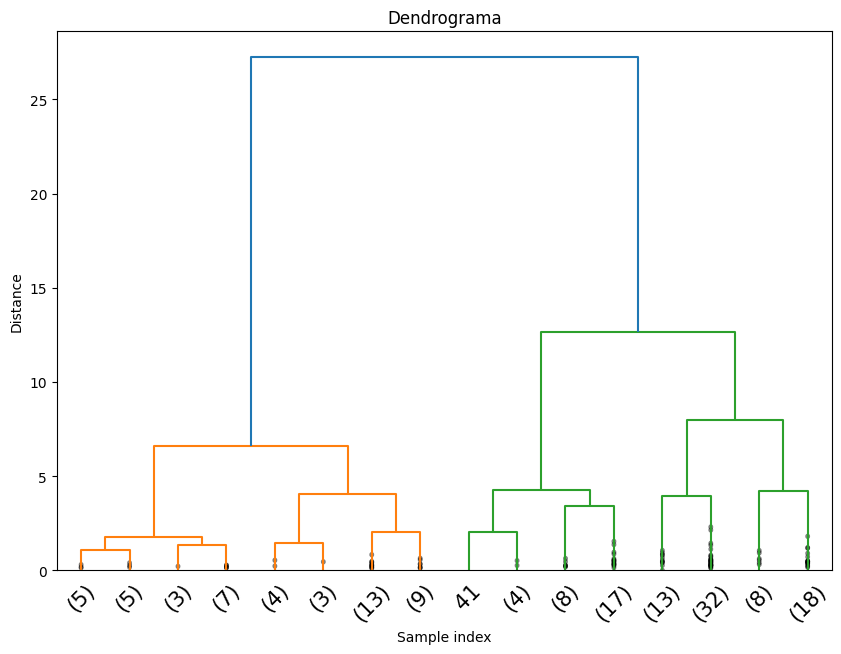

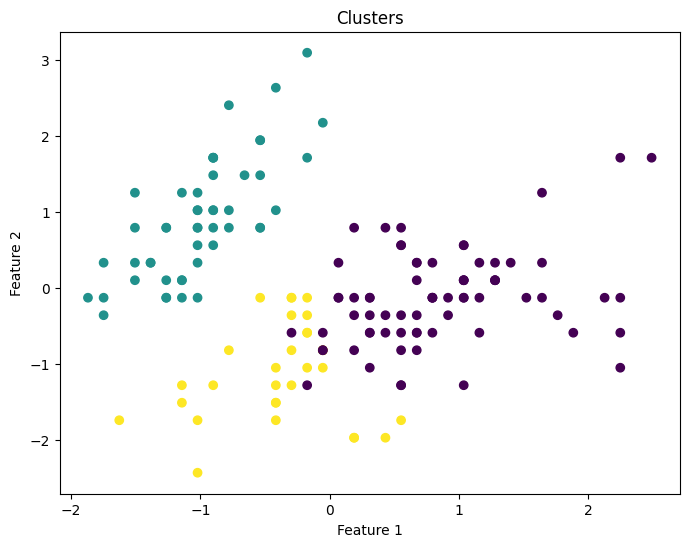

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.graph_objects as go

# Cargar el dataset
iris = datasets.load_iris()
X = iris.data

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear el modelo de clustering jerárquico
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

# Entrenar el modelo
labels = model.fit_predict(X_scaled)

# Evaluar el modelo
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Generar el dendrograma
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Dendrograma')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Scatter Plot con Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

+--------------------+----------+
|      scaledFeatures|prediction|
+--------------------+----------+
|[6.15892840883879...|         0|
|[5.91740180457060...|         0|
|[5.67587520030241...|         0|
|[5.55511189816832...|         0|
|[6.0381651067047,...|         0|
|[6.52121831524107...|         0|
|[5.55511189816832...|         0|
|[6.0381651067047,...|         0|
|[5.31358529390013...|         0|
|[5.91740180457060...|         0|
|[6.52121831524107...|         0|
|[5.79663850243651...|         0|
|[5.79663850243651...|         0|
|[5.19282199176604...|         0|
|[7.00427152377745...|         0|
|[6.88350822164335...|         0|
|[6.52121831524107...|         0|
|[6.15892840883879...|         0|
|[6.88350822164335...|         0|
|[6.15892840883879...|         0|
+--------------------+----------+
only showing top 20 rows

Cluster Centers:
[6.0454109  7.86479734 0.82818867 0.32273398]
[6.98801493 6.12396705 2.47288789 1.85688096]
[8.18422962 7.09315396 3.11090022 2.56918992]


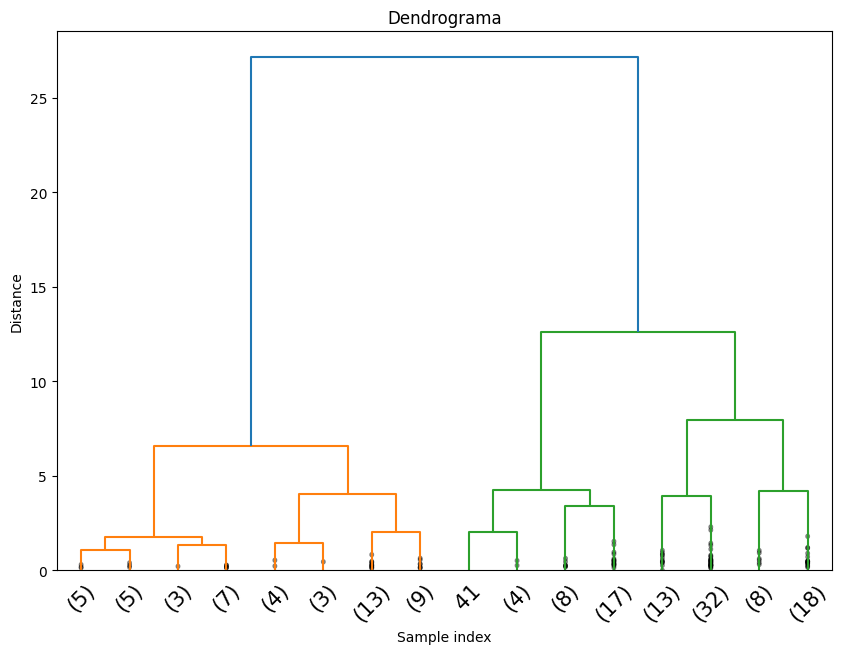

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import BisectingKMeans
from sklearn import datasets
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage

# Crear la sesión de Spark
spark = SparkSession.builder.appName('HierarchicalClustering').getOrCreate()

# Cargar el dataset
iris = datasets.load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Preparar los datos
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
data = assembler.transform(df_spark).select('features')

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data).select('scaledFeatures')

# Crear el modelo de clustering jerárquico (usamos BisectingKMeans como ejemplo análogo)
bkmeans = BisectingKMeans(k=3, seed=42, featuresCol='scaledFeatures', predictionCol='prediction')

# Entrenar el modelo
model = bkmeans.fit(data)

# Evaluar el modelo
predictions = model.transform(data)
predictions.show()

# Mostrar los centroides
centers = model.clusterCenters()
print('Cluster Centers:')
for center in centers:
    print(center)

# Convertir las características escaladas a formato numpy array
X_scaled = np.array([row['scaledFeatures'] for row in data.collect()])

# Generar el dendrograma (con scipy para visualización)
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Dendrograma')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Visualización de Clusters (ejemplo simple)
predictions_pd = predictions.toPandas()
fig = go.Figure()
fig.add_trace(go.Scatter(x=predictions_pd['scaledFeatures'].apply(lambda x: x[0]),
                         y=predictions_pd['scaledFeatures'].apply(lambda x: x[1]),
                         mode='markers',
                         marker=dict(color=predictions_pd['prediction']),
                         name='Data Points'))
fig.update_layout(title='Clusters',
                  xaxis_title='Feature 1',
                  yaxis_title='Feature 2',
                  showlegend=False)
fig.show()